# CIFAR Image Classification

CIFAR-10  is an established computer-vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.


In this classification, we aim to correctly identify the object from a dataset of tens of thousands of images by using the Convolutional Neural Network(PyTorch)

There are 10 categories an image may fall under:
0. airplane
1. automobile
2. bird
3. cat
4. deer
5. dog
6. frog
7. horse
8. ship
9. truck

# Import the Libraries

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

## Loading the Dataset from TorchVision

In [2]:
from torchvision import datasets, transforms
transform = transforms.ToTensor()

In [3]:
train_data = datasets.CIFAR10(root='/Documents', train=True, download=True, transform=transform)
train_data

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /Documents
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
type(train_data)

torchvision.datasets.cifar.CIFAR10

In [5]:
len(train_data)

50000

In [6]:
test_data = datasets.CIFAR10(root='/Documents', train=False, download=True, transform=transform)
test_data

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /Documents
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([3, 32, 32]) 
Label: 6


In [8]:
image, label = test_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([3, 32, 32]) 
Label: 3


From the above result we can see that the dimension of the image is ``3 x 32x 32`` which indicates that the ``height = 32``, ``widith  = 32`` and ``color channel is 3`` which is Red,Green and Blue(RGB)

In [18]:
class_names= ['Plane','Car','Bird','Cat', 'Deer','Dog','Frog','Horse','Ship','Truck']

Label: [    3     2     0     4     9     5     1     2     4     8]
Class:  cat bird plane deer truck dog car bird deer ship


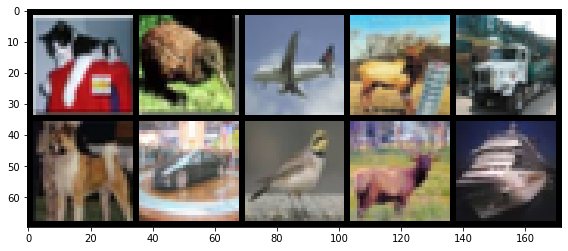

In [13]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array
from torchvision.utils import make_grid
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

# Data Loading Strategy

As there are more than 30k rows its not wise to feed all the data once into the CNN model. Instead we will try to feed the data in batches to the model using Dataset and DataLoader feature of Torch library

In [11]:
from torch.utils.data import TensorDataset, DataLoader

In [12]:
"""
Initializing train/test dataloader object which splits the training dataset into small batches of 10 images each
and this can be used later in the CNN model  
"""
torch.manual_seed(101)
bat_sz=10
train_loader = DataLoader(train_data,batch_size=bat_sz,shuffle=True)
test_loader = DataLoader(test_data,batch_size=bat_sz,shuffle=False)

# Define the CNN Model

In [14]:
class CONVNN(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.conv1  = nn.Conv2d(3, 6 , kernel_size =5, stride=1)#3 color channels as input and We will be using 5X5 filter/kernel and stride of 1 without any padding 
        self.conv2  = nn.Conv2d(6, 16, 5 , 1)
        self.layer1 = nn.Linear(5*5*16,120) # we need to calculate the resulting number of matrices passing thru the conv layer and put that corressponding o/p as the linear layer input
        self.layer2 = nn.Linear(120,84)
        self.layer3 = nn.Linear(84,10)
        
    def forward(self,x):
        
        x= F.max_pool2d(  F.relu(self.conv1(x)) , 2, 2) #adding relu and max pooling with 2x2 kernel and stride of 2
        x= F.max_pool2d(  F.relu(self.conv2(x)) , 2, 2) #adding relu and max pooling the same line
        x= F.relu(self.layer1(x.view(-1,5*5*16)))       #flattening by using View and no dropout has been added
        x= F.relu(self.layer2(x))
        x= F.log_softmax(self.layer3(x),dim=1)          #multiclass classificaiton
        
        return x
    

### How the input parameters for the linear layer is calcualted:    
At first we have 32X32 image which was filtered by 5X5 kernel as we don't have padding the last 4 pixels wont be 
scanned hence there will be a loss of 4 pixels along row and column thus the resulting image of the kernel will be
(32-4)X(32-4) = (28X28) then it is passed to the max_pool where it reduced half or what was there before hence the output
will be  (28/2 X 28/2) = (14X14) then again we will have a conv layer which is scanned by a 5X5 kernel and looses the 
last 4 pixels in both rows and columns which resulted in(14-4  14-4) = (10X10) then max pooling occurs so 
( 10/2 X 10/2) = (5X5). finally the input layer of Linear will take 5X5 matrix of image with the number of conv layers just
before the linear layer is 16 = > 16*5*5

In [15]:
torch.manual_seed(101)
model = CONVNN()
model

CONVNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (layer1): Linear(in_features=400, out_features=120, bias=True)
  (layer2): Linear(in_features=120, out_features=84, bias=True)
  (layer3): Linear(in_features=84, out_features=10, bias=True)
)

# Define Loss and Optimizer

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

# Training the CNN Model

In [17]:
epochs = 5
train_loss= []
test_loss= []
train_acc=[]
test_acc = []

print(f'\nConvolutional Neural Network Model Metrics:\n')
print(f'\t This CNN model configuration has {epochs} epochs with each batch size of {bat_sz} images:\n')
for i in range(epochs):
    
    train_crt_pred = 0
    test_crt_pred = 0
    conf_mat= torch.FloatTensor([])
    
    for b,(x_train,y_train) in enumerate (train_loader):
        b += 1
        y_pred = model.forward(x_train)
        loss= criterion(y_pred,y_train)
        
        buffer = torch.max(y_pred.data, 1) [1]
        batch_acc = (buffer == y_train).sum()
        train_crt_pred +=  batch_acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        if b%  int((len(train_data)/bat_sz)/5 )  == 0:
            print(f'Epoch{i+1:2} Batch {b:4} loss: {loss.item():5.2f} Train Accuracy: {train_crt_pred.item()*100/(bat_sz*b):6.3f}%')
    
    train_loss.append(loss)  #loss after 1 epoch
    train_acc.append(train_crt_pred) # crt predictions after 1 epoch
    
    
    with torch.no_grad():  #testing after 1 complete epoch
        for b,(x_test,y_test) in enumerate (test_loader):
            b += 1
            y_eval = model(x_test)
            loss= criterion(y_eval,y_test)
            buffer1 = torch.max(y_eval.data, 1) [1]
            conf_mat =  torch.cat((conf_mat.float(),buffer1.float()),0)
            batch_acc = (buffer1 == y_test).sum()
            test_crt_pred +=  batch_acc
    
    test_loss.append(loss) #test loss after the last completed epoch
    test_acc.append(test_crt_pred) # crt predictions using the last completed epoch

    print(f'After {i+1} Epoch(s) the Train Accuracy is {(train_crt_pred.item()/len(train_data))*100:6.3f}% and Test Accuracy is {(test_crt_pred.item()/len(test_data))*100:6.3f}% \n')     
    
        


Convolutional Neural Network Model Metrics:

	 This CNN model configuration has 5 epochs with each batch size of 10 images:

Epoch 1 Batch 1000 loss:  1.93 Train Accuracy: 25.280%
Epoch 1 Batch 2000 loss:  1.94 Train Accuracy: 30.520%
Epoch 1 Batch 3000 loss:  1.38 Train Accuracy: 33.997%
Epoch 1 Batch 4000 loss:  1.22 Train Accuracy: 36.455%
Epoch 1 Batch 5000 loss:  1.26 Train Accuracy: 38.028%
After 1 Epoch(s) the Train Accuracy is 38.028% and Test Accuracy is 46.590% 

Epoch 2 Batch 1000 loss:  0.99 Train Accuracy: 46.480%
Epoch 2 Batch 2000 loss:  1.77 Train Accuracy: 47.390%
Epoch 2 Batch 3000 loss:  1.13 Train Accuracy: 48.153%
Epoch 2 Batch 4000 loss:  1.33 Train Accuracy: 48.740%
Epoch 2 Batch 5000 loss:  1.35 Train Accuracy: 49.240%
After 2 Epoch(s) the Train Accuracy is 49.240% and Test Accuracy is 51.360% 

Epoch 3 Batch 1000 loss:  2.56 Train Accuracy: 53.260%
Epoch 3 Batch 2000 loss:  1.42 Train Accuracy: 53.435%
Epoch 3 Batch 3000 loss:  2.31 Train Accuracy: 53.687%
Epo

# Model Evaluation

In [19]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns


The Confusion Matrix is plotted below:


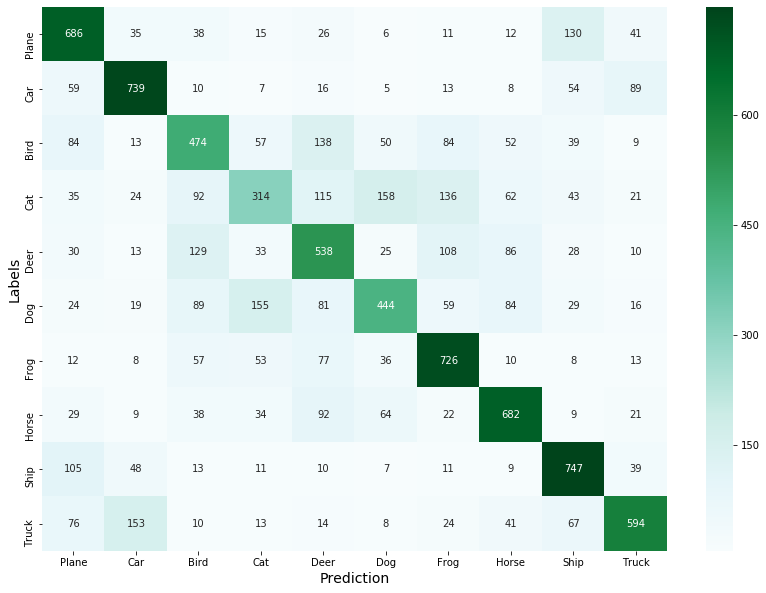


The Classification Report is plotted below: 

               precision    recall  f1-score   support

         0.0       0.60      0.69      0.64      1000
         1.0       0.70      0.74      0.72      1000
         2.0       0.50      0.47      0.49      1000
         3.0       0.45      0.31      0.37      1000
         4.0       0.49      0.54      0.51      1000
         5.0       0.55      0.44      0.49      1000
         6.0       0.61      0.73      0.66      1000
         7.0       0.65      0.68      0.67      1000
         8.0       0.65      0.75      0.69      1000
         9.0       0.70      0.59      0.64      1000

    accuracy                           0.59     10000
   macro avg       0.59      0.59      0.59     10000
weighted avg       0.59      0.59      0.59     10000



In [29]:
class_names=['Plane','Car','Bird','Cat', 'Deer','Dog','Frog','Horse','Ship','Truck']
print('\nThe Confusion Matrix is plotted below:')
cfmt =pd.DataFrame(confusion_matrix(torch.Tensor([r for q,r in test_data]).reshape(-1,1),conf_mat.reshape(-1,1),labels=[0,1,2,3,4,5,6,7,8,9]),index=class_names,columns=class_names)
plt.figure(figsize=(14,10))
sns.heatmap(cfmt,annot=True,cmap='BuGn',fmt="d")
plt.xlabel("Prediction",fontsize=14)
plt.ylabel("Labels",fontsize=14)
plt.show()
print('\nThe Classification Report is plotted below: \n\n',classification_report(torch.Tensor([r for q,r in test_data]).reshape(-1,1),conf_mat.reshape(-1,1)))


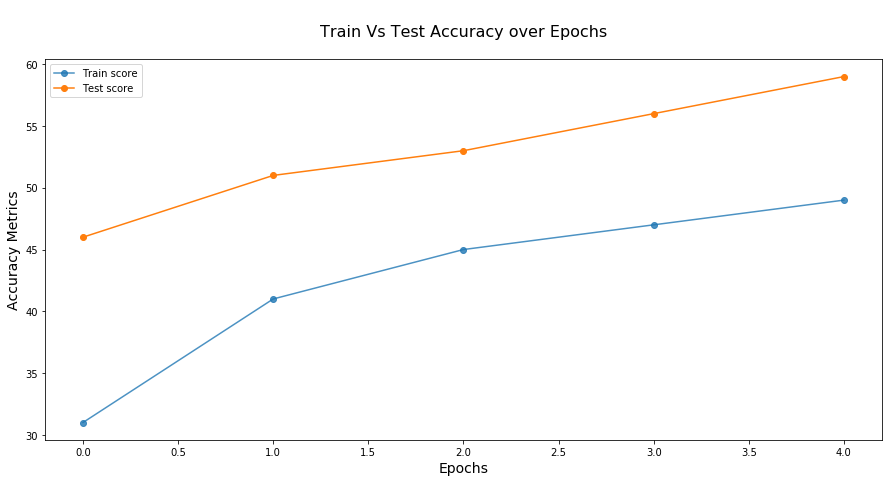

In [30]:
plt.figure(figsize=(15,7))
plt.plot([t/600 for t in train_acc], label='Train score',marker='o',alpha=0.8)
plt.plot([t/100 for t in test_acc], label='Test score',marker='o')
plt.title('\nTrain Vs Test Accuracy over Epochs\n',fontsize=16)
# plt.xticks(np.arange(0,20,1));
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Accuracy Metrics',fontsize=14)
plt.legend();

From above we can see that, at the epoch 5 we have better Test results we can run more epochs if necessary

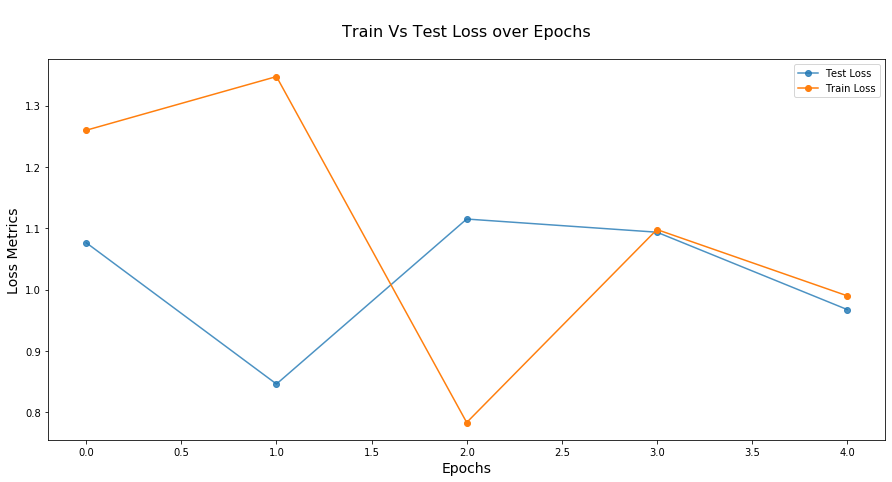

In [31]:
plt.figure(figsize=(15,7))
plt.plot([t for t in test_loss], label='Test Loss',marker='o',alpha=0.8)
plt.plot([t for t in train_loss], label='Train Loss',marker='o')
plt.title('\nTrain Vs Test Loss over Epochs\n',fontsize=16)
# plt.xticks(np.arange(0,20,1));
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Loss Metrics',fontsize=14)
plt.legend();

# Save the Model

In [32]:
torch.save(model.state_dict(), 'cifar10_CNN.pt')